In [1]:
# Bruno Ugolini
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

# 1. Twitch API data

The URL `https://wind-bow.glitch.me/twitch-api/channels/{CHANNEL_NAME}` is an API from twitch to get data from twitch channels.

Get the data from the following channels:

```
["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
    "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
    "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
    "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
    "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
    "sivhd", "kingrichard"]
```

To make into a dataframe that looks like this:

![](twitch.png)

In [2]:
channels = ["ESL_SC2", "OgamingSC2", "cretetion", "freecodecamp", 
            "storbeck", "habathcx", "RobotCaleb", "noobs2ninjas",
            "ninja", "shroud", "Dakotaz", "esltv_cs", "pokimane", 
            "tsm_bjergsen", "boxbox", "wtcn", "a_seagull",
            "kinggothalion", "amazhs", "jahrein", "thenadeshot", 
            "sivhd", "kingrichard"]
col_names = ['_id', 'display_name', 'status', 'followers', 'views']
df = pd.DataFrame()
for channel in channels:
    rc = requests.get(f"https://wind-bow.glitch.me/twitch-api/channels/{channel}") #only 8
    if rc.status_code == 200:
        print(f"user: {channel} exists")
        df = pd.concat([df,
                        pd.DataFrame.from_dict(json.loads(rc.content))],
                       axis=0)
    else:
        print(f"\tuser: {channel} no longer exists")


user: ESL_SC2 exists
user: OgamingSC2 exists
user: cretetion exists
user: freecodecamp exists
user: storbeck exists
user: habathcx exists
user: RobotCaleb exists
user: noobs2ninjas exists
	user: ninja no longer exists
	user: shroud no longer exists
	user: Dakotaz no longer exists
	user: esltv_cs no longer exists
	user: pokimane no longer exists
	user: tsm_bjergsen no longer exists
	user: boxbox no longer exists
	user: wtcn no longer exists
	user: a_seagull no longer exists
	user: kinggothalion no longer exists
	user: amazhs no longer exists
	user: jahrein no longer exists
	user: thenadeshot no longer exists
	user: sivhd no longer exists
	user: kingrichard no longer exists


In [3]:
df = df.loc[df.index == 'self', col_names]
df = df.reset_index(drop=True)
df

,_id,display_name,status,followers,views
0,30220059,ESL_SC2,RERUN: StarCraft 2 - Terminator vs. Parting (P...,135394,60991791
1,71852806,OgamingSC2,UnderDogs - Rediffusion - Qualifier.,40895,20694507
2,90401618,cretetion,It's a Divison kind of Day,908,11631
3,79776140,FreeCodeCamp,Greg working on Electron-Vue boilerplate w/ Ak...,10122,163747
4,86238744,storbeck,None,10,1019
5,6726509,Habathcx,Massively Effective,14,764
6,54925078,RobotCaleb,Code wrangling,20,4602
7,82534701,noobs2ninjas,Building a new hackintosh for #programming and...,835,48102


# 2. App Store Reviews

The Apple app store has a `GET` API to get reviews on apps. The URL is:

```
https://itunes.apple.com/{COUNTRY_CODE}/rss/customerreviews/id={APP_ID_HERE}/page={PAGE_NUMBER}/sortby=mostrecent/json
```

Note that you need to provide:

- The country code (eg. `'us'`, `'gb'`, `'ca'`, `'au'`) 

- The app ID. This can be found in the web page for the app right after `id`. For instance, Candy Crush's US webpage is:

`https://apps.apple.com/us/app/candy-crush-saga/id553834731`

So here the ID would be `553834731`.

- The "Page Number". The request responds with multiple pages of data, but sends them one at a time. So you can cycle through the data pages for any app on any country.

### 2.1 English app reviews

Get all english reviews you can for Candy Crush, Tinder, the Facebook app and Twitter (you have to get them from all the english-speaking countries you can think of!).

### 2.2 Best version

For each app, get the version that is the best rated.

Make a visualization of the ratings per versions per app to show this.

### 2.3 Top words

Which word for each app is most common in the 5 star and in the 1-star review's titles?

Note: `df.title.str.get_dummies()` is your friend

Note: This might create a lot of data! Try to break down your analysis in chunks if it doesn't work.

# Question 2.1: English app reviews

In [12]:
# App names and id's
apps = {'Candy Crush': 553834731, 'Tinder': 547702041, 'Facebook': 284882215, 'Twitter': 333903271}
# english country codes
en_cc = ['us', 'ca', 'gb', 'au', 'nz']
# divide up the columns by their unique
# dictionary attributes
col_names = ['im:version', 'im:rating', 'id', 
             'title', 'content', 'im:voteSum', 
             'im:voteCount']
col2_names = {'author': 'name', 'im:contentType': 'attributes'}
col3_names = {'link': 'attributes'}
df_master = pd.DataFrame()

In [13]:
for app, idx in apps.items():
    for cc in en_cc:
        cnt = 0 # number of reviews counter
        for i in range(1,11): # api limits to 10 pages
            df = pd.DataFrame()
            r = requests.get(f"https://itunes.apple.com/{cc}/rss/customerreviews/id={idx}/page={i}/sortby=mostrecent/json")
            if r.status_code == 200:
                d = json.loads(r.content)
                df = pd.DataFrame.from_dict(d['feed']['entry'])
                # do columns where 'label' is accessible
                for col in col_names:
                    df[col] = df[col].apply(lambda x: x['label'])
                # do columns where 'label' is one layer deeper
                for col, attr in col2_names.items():
                    df[col] = df[col].apply(lambda x: x[attr]['label'])
                # do columns where 'href' is the desired name
                for col, attr in col3_names.items():
                    df[col] = df[col].apply(lambda x: x[attr]['href'])
                # add country and app title
                df['title'] = app
                df['country'] = cc
                cnt += len(df)
                df_master = pd.concat([df_master,df],axis=0,ignore_index=True)
        print(f"There were {cnt} reviews for {app} in {cc}.")

There were 500 reviews for Candy Crush in us.
There were 500 reviews for Candy Crush in ca.
There were 500 reviews for Candy Crush in gb.
There were 500 reviews for Candy Crush in au.
There were 500 reviews for Candy Crush in nz.
There were 500 reviews for Tinder in us.
There were 500 reviews for Tinder in ca.
There were 500 reviews for Tinder in gb.
There were 500 reviews for Tinder in au.
There were 500 reviews for Tinder in nz.
There were 500 reviews for Facebook in us.
There were 500 reviews for Facebook in ca.
There were 500 reviews for Facebook in gb.
There were 500 reviews for Facebook in au.
There were 500 reviews for Facebook in nz.
There were 500 reviews for Twitter in us.
There were 500 reviews for Twitter in ca.
There were 500 reviews for Twitter in gb.
There were 500 reviews for Twitter in au.
There were 500 reviews for Twitter in nz.


In [14]:
# check size: (4 apps) x (5 countries) x (10 pages limit) x (50 review/page) = 10,000
len(df_master)

10000

In [15]:
df_master.sample(5)

,author,im:version,im:rating,id,title,content,link,im:voteSum,im:contentType,im:voteCount,country
4951,Crazy horse 9965,7.1.1,1,1573677959,Tinder,Since doing the updates. There is no tinder ap...,https://itunes.apple.com/nz/review?id=54770204...,0,Application,0,nz
1846,Tyarena,1.161.0,1,4960116034,Candy Crush,I have been buying the in game gold for a whil...,https://itunes.apple.com/au/review?id=55383473...,0,Application,0,au
6499,JohnyBruce,301.0,1,6887867187,Facebook,I am sure Facebook started off with good inten...,https://itunes.apple.com/gb/review?id=28488221...,0,Application,0,gb
2937,Morty8274839,12.1.0,1,6987998073,Tinder,"Like many others, one day I signed in and saw ...",https://itunes.apple.com/us/review?id=54770204...,1,Application,1,us
1309,ell👲,1.183.0.3,5,6362532059,Candy Crush,I played this when I was seven then it was uni...,https://itunes.apple.com/gb/review?id=55383473...,0,Application,0,gb


## Question 2.2: Best version

In [16]:
df_master['im:rating'] = df_master['im:rating'].astype(int)

### The following code looks at each app separately and gets the mean rating per version

Candy Crush version with most five star ratings:
	            im:rating  user_count
im:version                       
1.122.0           5.0           6
1.110.1           5.0           5
1.106.0           5.0           3
1.125.0           5.0           1
	Total number of users: 2500

Tinder version with most five star ratings:
	            im:rating  user_count
im:version                       
7.3.0             5.0           3
7.8.0             5.0           2
11.0.2            5.0           1
7.4.0             5.0           1
	Total number of users: 2500

Facebook version with most five star ratings:
	            im:rating  user_count
im:version                       
238.0             5.0           1
239.0             3.0           5
261.0             3.0           2
282.0             3.0           1
	Total number of users: 2500

Twitter version with most five star ratings:
	            im:rating  user_count
im:version                       
6.7.2             5.0           4
7.30    

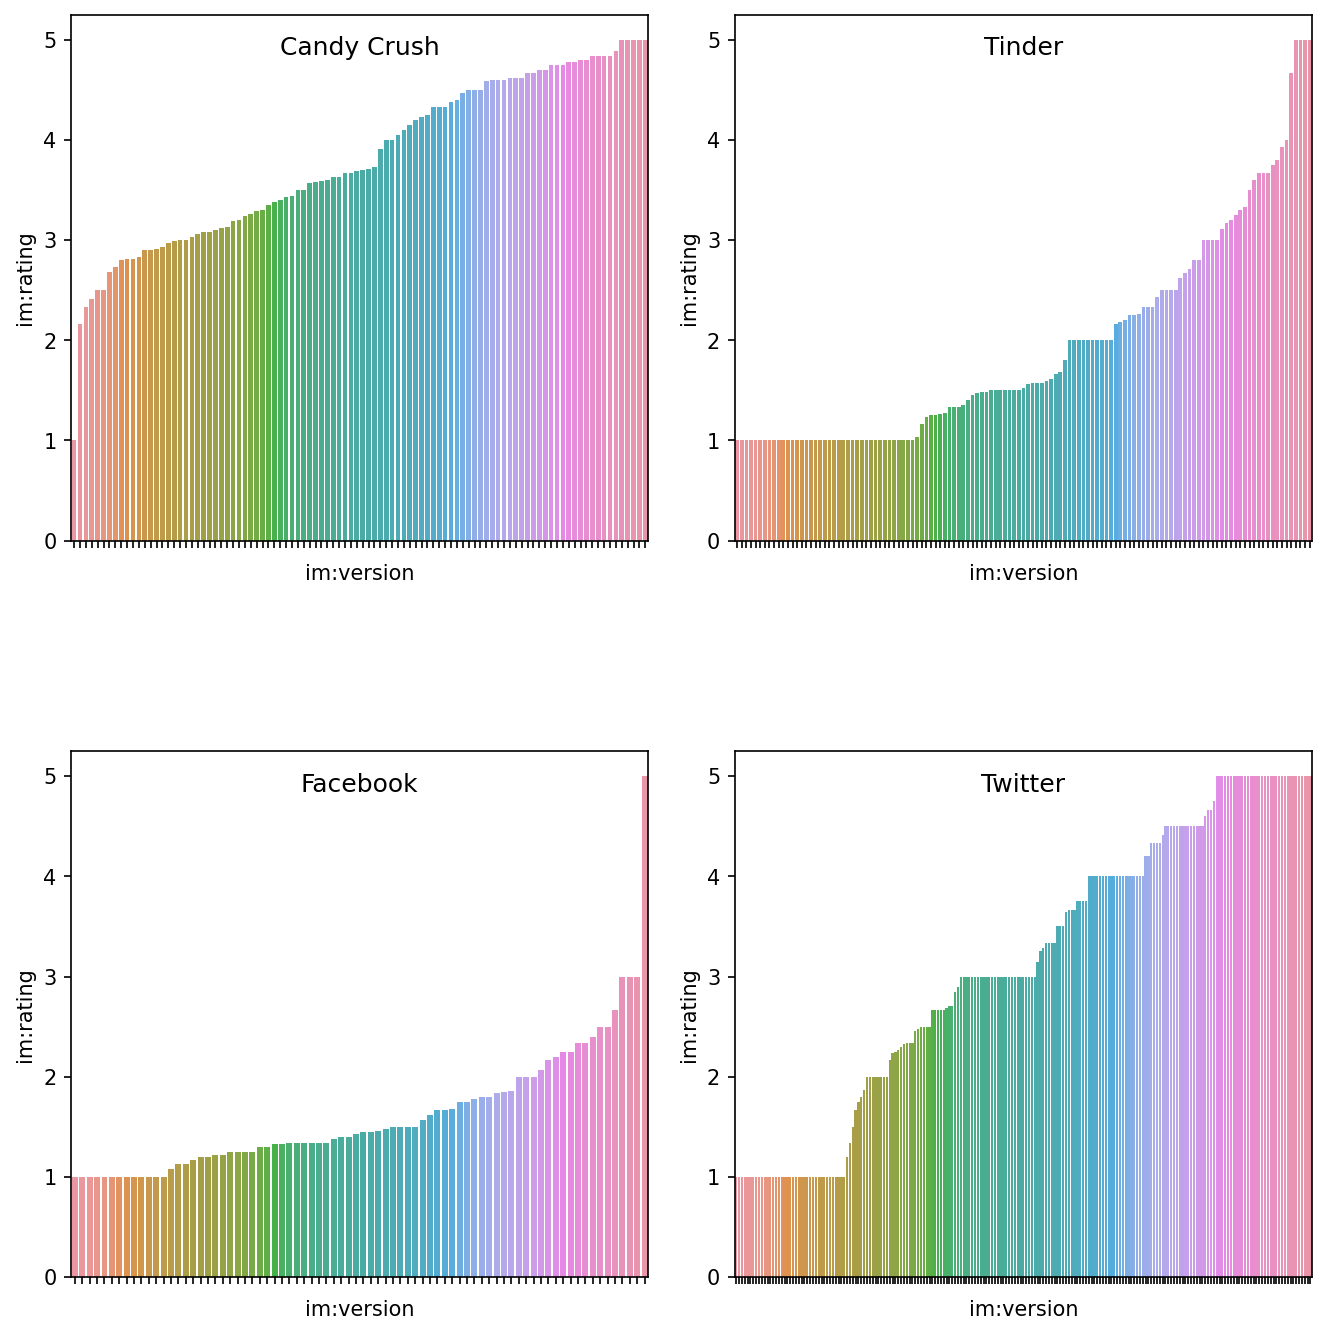

In [36]:
fig, ax = plt.subplots(2,2,dpi=150,figsize=(9,9))
fig.tight_layout()
i=0
for k, _ in apps.items():
    nrow = i // 2
    ncol = i % 2
    data_grp = df_master.loc[df_master.title==k].groupby(by=['title','im:version'])
    data = pd.merge(left=data_grp.mean(),
                    right=data_grp.count()['id'],
                    left_index=True,
                    right_index=True).droplevel(0)
    data.columns = ['im:rating', 'user_count']
    sns.barplot(data=data.sort_values(by='im:rating'), x=data.index, y='im:rating',ax=ax[nrow,ncol])
    ax[nrow,ncol].set_title(k,y=0.9)
    locs, labels = plt.xticks()
#    ax[nrow,ncol].set_xticklabels(ax[nrow,ncol].get_xticklabels(), rotation = 90)
    ax[nrow,ncol].set_xticklabels([])
    i += 1
    best = data.sort_values(by=['im:rating','user_count'],ascending=False).head(4)
    print(f"{k} version with most five star ratings:\n\t{best}")
    print(f"\tTotal number of users: {data['user_count'].sum()}\n")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.15, hspace=0.4)

### According to the above, the best versions were:
### > Candy Crush: version 1.122.0
### > Tinder: version 7.3.0
### > Facebook: version 238.0
### > Twitter:  version 6.7.2

## Question 2.3: Top Words

## I decided to write a class in order to create a vocabulary of the words and their occurences.

In [37]:
import regex as re
import string
# exclist = string.punctuation + string.digits
# df.at[0, 'content'].strip(exclist).lower()

In [38]:
class WordCountDict():
    """
    creates a dictionary with a count for 
    each word that appears.
    """
    
    def __init__(self):
        self.dic = {}
        
    def add(self, line):
        words = re.sub(r"[^\w\d'\s]+", ' ', line).lower().strip().split()
        for word in words:
            if len(word) == len(word.encode(encoding='utf_8')):
                try:
                    self.dic[word] += 1
                except:
                    self.dic[word] = 0

In [40]:
import collections
Words = collections.namedtuple('Words', ['Count','Word'])
num = 3

for k, _ in apps.items():
    for rating in [1, 5]:
        data = df_master.loc[(df_master.title==k) & (df_master['im:rating'] == rating)]
        contents_dic = WordCountDict()
        f = lambda x : contents_dic.add(x)
        data.content.apply(f)
        max_word = max(contents_dic.dic, key=contents_dic.dic.get)
        cnt = contents_dic.dic[max_word]
        print(f"The most used word in the comments for {k} with rating {rating} is '{max_word}' with {cnt} occurences")
        best = sorted([Words(v,k) for (k,v) in contents_dic.dic.items()], reverse=True)
        print(f"\tThe highest {num} counts in this category were:")
        for i in range(num):
            dum = best[i]
            print(f"\t\t'{dum.Word}' with {dum.Count} occurences")

The most used word in the comments for Candy Crush with rating 1 is 'to' with 1165 occurences
	The highest 3 counts in this category were:
		'to' with 1165 occurences
		'i' with 1141 occurences
		'the' with 1101 occurences
The most used word in the comments for Candy Crush with rating 5 is 'i' with 691 occurences
	The highest 3 counts in this category were:
		'i' with 691 occurences
		'game' with 622 occurences
		'it' with 523 occurences
The most used word in the comments for Tinder with rating 1 is 'i' with 3409 occurences
	The highest 3 counts in this category were:
		'i' with 3409 occurences
		'and' with 2569 occurences
		'to' with 2502 occurences
The most used word in the comments for Tinder with rating 5 is 'i' with 145 occurences
	The highest 3 counts in this category were:
		'i' with 145 occurences
		'to' with 99 occurences
		'the' with 84 occurences
The most used word in the comments for Facebook with rating 1 is 'the' with 2264 occurences
	The highest 3 counts in this category

# 3 (STRETCH) IMDB scraping

IMDB has structured web pages. We can exploit this to scrape movie data.

Usinf the following URL:

`https://www.imdb.com/search/title/?groups=top_1000&start={PAGE_NUMBER}&ref_=adv_nxt`

With the following headers in your `GET` request: `{"Accept-Language": "en-US,en;q=0.5"}`

You can generate a dataframe like this one by cycling over the page numbers in the URL requested:

![](IMDB.png)

Note that the following  page attribues will be of interest:

- `div` with a class of `lister-item mode-advanced`

- Various `span` objects within that `div` like `lister-item-year` and `runtime` and `metascore`